In [1]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
sb.set_color_codes()

In [2]:
# lin = np.linspace(-100, 100, 201)
# x, y = np.meshgrid(lin, lin)
# print x.shape, y.shape
# data = np.empty(x.shape + (2,))
# data[:,:,0] = x
# data[:,:,1] = y
# rv = multivariate_normal(mean=[-66., -66.], cov=[[10, 0.], [0., 10]])
# logp = -rv.logpdf(data)
# rv = multivariate_normal(mean=[66., -66.], cov=[[10, 0.], [0., 10]])
# logp -= rv.logpdf(data)
# rv = multivariate_normal(mean=[0., 50.], cov=[[10, 0.], [0., 10]])
# logp -= rv.logpdf(data)
# plt.contourf(logp)

# plt.grid(False)
# plt.colorbar()
# # plt.xlim(min(lin), max(lin))
# # plt.ylim(min(lin), max(lin))
# # print data
# # f, ax = plt.subplots(figsize=(7, 7))
# # sb.kdeplot(data, shade=True, ax=ax)

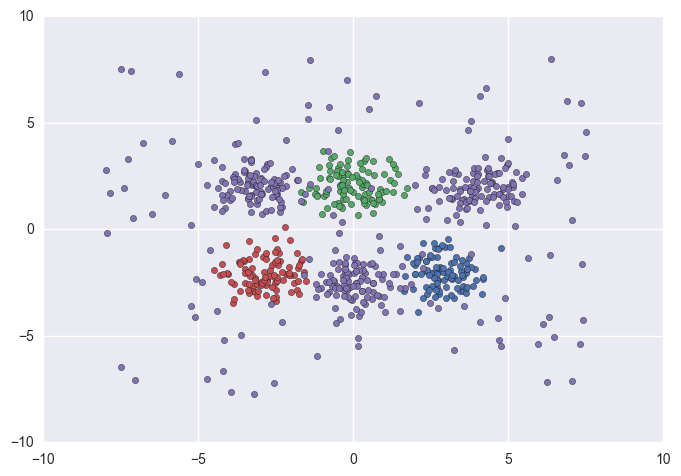

In [3]:
c1 = np.random.multivariate_normal([-3, -2], [[.5, 0.], [0., .5]], size=100)
c2 = np.random.multivariate_normal([3, -2], [[.5, 0.], [0., .5]], size=100)
c3 = np.random.multivariate_normal([0, 2], [[.5, 0.], [0., .5]], size=100)

# nearby distributions
c4 = np.random.multivariate_normal([-3, 2], [[.5, 0.], [0., .5]], size=100)
c5 = np.random.multivariate_normal([4, 2], [[.5, 0.], [0., .5]], size=100)
c6 = np.random.multivariate_normal([0, -2.5], [[.5, 0.], [0., .5]], size=100)
c7 = np.random.uniform(-8, 8, size=(100,2))
other = np.vstack([c4, c5, c6, c7])

# general uniform
# other = np.random.uniform(-8, 8, size=(100,2))
# print other.shape

plt.scatter(c1[:,0], c1[:,1], c='r')
plt.scatter(c2[:,0], c2[:,1], c='b')
plt.scatter(c3[:,0], c3[:,1], c='g')
plt.scatter(other[:,0], other[:,1], c='m')


x = np.vstack([c1, c2, c3, other])
y = np.vstack([np.zeros((c1.shape[0], 1)),
               np.ones((c2.shape[0], 1)),
               2*np.ones((c3.shape[0], 1)),
               3*np.ones((other.shape[0], 1))]).reshape(-1).astype(np.int32)

In [4]:
print x.shape, y.shape

(700, 2) (700,)


In [16]:
import tensorflow as tf

class LogisticRegression(object):
    def __init__(self, d, c, h=10, lr=.001, session=None, implicit_other=False):
        print "Building...",
        self.d = d
        self.c = c
        self.h = h
        self.lr = lr
        self.implicit_other = implicit_other
        
        self.build_forward()
        self.build_loss()
        self.build_optimizer()
        
        self.losses = []
        
        if session:
            self.session = session
        else:
            self.session = tf.InteractiveSession()
        self.session.run(tf.initialize_all_variables())
        print "Done"
        
    def build_forward(self):
        self.x = tf.placeholder(tf.float32, [None, self.d])
        self.y = tf.placeholder(tf.int32, [None])
        
        # hidden layer
        Wh = tf.Variable(tf.random_normal(dtype=tf.float32, mean=0., shape=[self.d, self.h]))
        bh = tf.Variable(tf.zeros(dtype=tf.float32, shape=[self.h]))
    
        # logit layer
        W = tf.Variable(tf.random_normal(dtype=tf.float32, mean=0., shape=[self.h, self.c]))
        b = tf.Variable(tf.zeros(dtype=tf.float32, shape=[self.c]))
        
        # forward network
        l1 = tf.nn.relu(tf.matmul(self.x, Wh) + bh)
        self.logits = tf.matmul(l1, W) + b
        
        # add in the other class score
        if self.implicit_other:
            self.logits = tf.concat(1, [self.logits, -tf.reduce_sum(self.logits, 1, keep_dims=True)])
        
        # hard decide labels ahead of time for when all score negative
        allneg_mask = tf.reduce_all(tf.less(self.logits, tf.zeros_like(self.logits), 1)
                                    
        self.labels = tf.argmax(self.logits, 1)
        self.probs = tf.nn.softmax(self.logits)
        
    def build_loss(self):
        self.loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(self.logits, self.y))
        
    def build_optimizer(self):
        optimizer = tf.train.AdamOptimizer(learning_rate=self.lr)
        self.train_op = optimizer.minimize(self.loss)
        
    def partial_fit(self, x, y):
        loss, _ = self.session.run([self.loss, self.train_op],
                                   {self.x:x, self.y:y})
        self.losses.append(loss)
        return loss
    
#     def fit(self, x, y):
        
    
    def predict(self, x):
        labels = self.session.run(self.labels, {self.x:x})
        return labels
    
    def predict_proba(self, x):
        probs = self.session.run(self.probs, {self.x:x})
        return probs

# With the implicit other

Building... Done
 Loss(i=999): 0.0870417878032
Accuracy: 0.971428571429


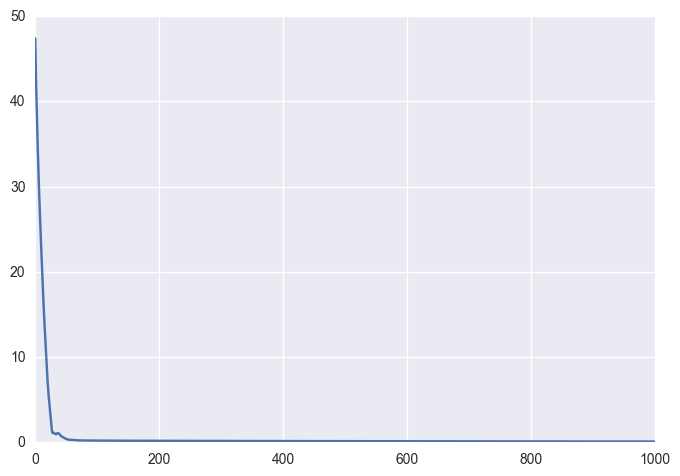

In [23]:
tf.reset_default_graph()
sess = tf.InteractiveSession()
model = LogisticRegression(2, 3, h=100, lr=.01, session=sess, implicit_other=True)

for i in range(1000):
    print '\r Loss(i={}): {}'.format(i, model.partial_fit(x, y)),
    
print
preds = model.predict(x)
print "Accuracy: {}".format(np.sum(preds == y) / float(len(y)))
plt.plot(range(len(model.losses)), model.losses)

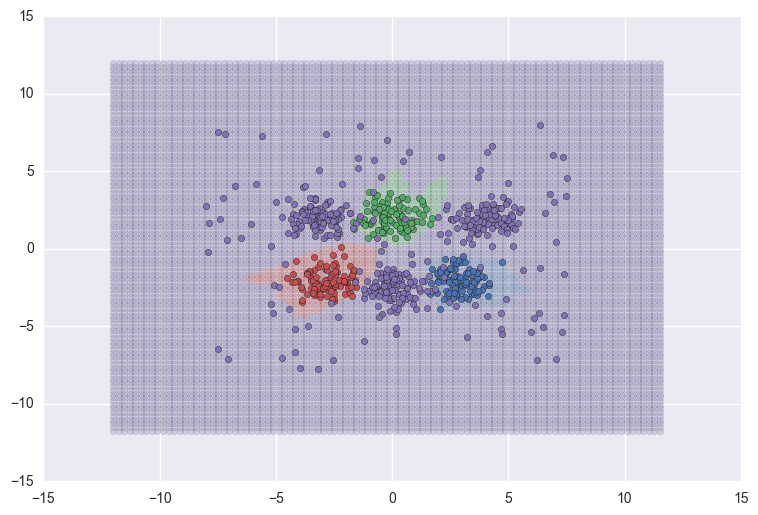

In [24]:
n=100
grid = np.empty((n**2, 2))
m = 4
xmin, xmax = np.min(x[:,0])-m, np.max(x[:,0])+m
ymin, ymax = np.min(x[:,1])-m, np.max(x[:,1])+m
for i, x0 in enumerate(np.linspace(xmin, xmax, n)):
    for j, y0 in enumerate(np.linspace(ymin, ymax, n)):
        grid[i*n+j, 0] = x0
        grid[i*n+j, 1] = y0
        
grid_preds = model.predict(grid)

fig, ax = plt.subplots(1, figsize=(9,6))# grid
c = grid[grid_preds == 0]
ax.scatter(c[:,0], c[:,1], c='r', alpha=.25)
c = grid[grid_preds == 1]
ax.scatter(c[:,0], c[:,1], c='b', alpha=.25)
c = grid[grid_preds == 2]
ax.scatter(c[:,0], c[:,1], c='g', alpha=.25)
c = grid[grid_preds == 3]
ax.scatter(c[:,0], c[:,1], c='m', alpha=.25)

# pred data
# c = x[preds == 0]
# plt.scatter(c[:,0], c[:,1], c='r')
# c = x[preds == 1]
# plt.scatter(c[:,0], c[:,1], c='b')
# c = x[preds == 2]
# plt.scatter(c[:,0], c[:,1], c='g')

# true data
c = x[y == 0]
ax.scatter(c[:,0], c[:,1], c='r')
c = x[y == 1]
ax.scatter(c[:,0], c[:,1], c='b')
c = x[y == 2]
ax.scatter(c[:,0], c[:,1], c='g')
c = x[y == 3]
ax.scatter(c[:,0], c[:,1], c='m')

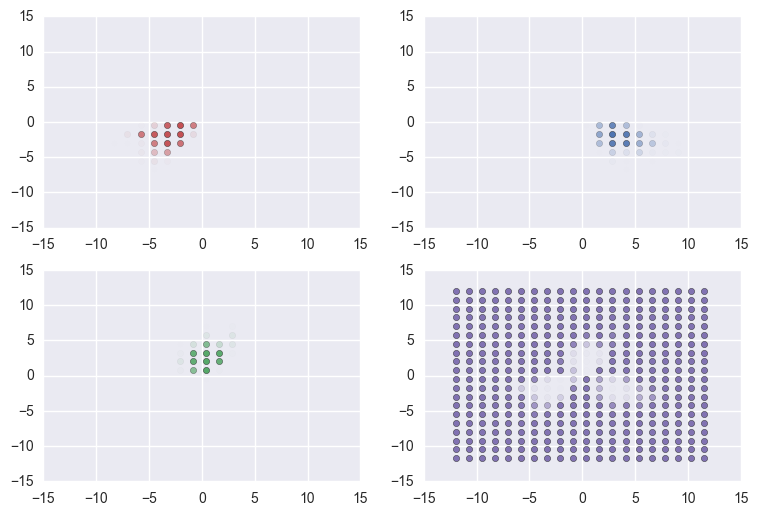

In [25]:
n=20
grid = np.empty((n**2, 2))
m = 4
xmin, xmax = np.min(x[:,0])-m, np.max(x[:,0])+m
ymin, ymax = np.min(x[:,1])-m, np.max(x[:,1])+m
for i, x0 in enumerate(np.linspace(xmin, xmax, n)):
    for j, y0 in enumerate(np.linspace(ymin, ymax, n)):
        grid[i*n+j, 0] = x0
        grid[i*n+j, 1] = y0
        
grid_probs = model.predict_proba(grid)

fig, axs = plt.subplots(2,2, figsize=(9,6))# grid
for i, x0 in enumerate(grid):
    axs[0,0].scatter(x0[0], x0[1], c='r', alpha=grid_probs[i,0])
    axs[0,1].scatter(x0[0], x0[1], c='b', alpha=grid_probs[i,1])
    axs[1,0].scatter(x0[0], x0[1], c='g', alpha=grid_probs[i,2])
    axs[1,1].scatter(x0[0], x0[1], c='m', alpha=grid_probs[i,3])


# Modeling other explicitly

Building... Done
 Loss(i=999): 0.0859015882015
Accuracy: 0.974285714286


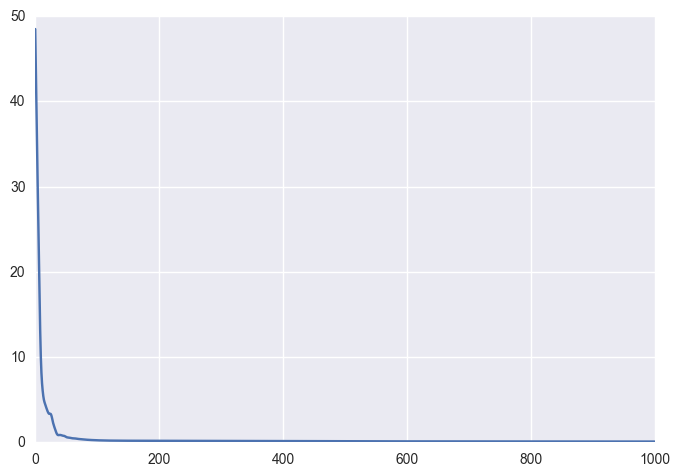

In [26]:
tf.reset_default_graph()
sess = tf.InteractiveSession()
model = LogisticRegression(2, 4, h=100, lr=.01, session=sess, implicit_other=False)

for i in range(1000):
    print '\r Loss(i={}): {}'.format(i, model.partial_fit(x, y)),
    
preds = model.predict(x)
print
print "Accuracy: {}".format(np.sum(preds == y) / float(len(y)))
plt.plot(range(len(model.losses)), model.losses)

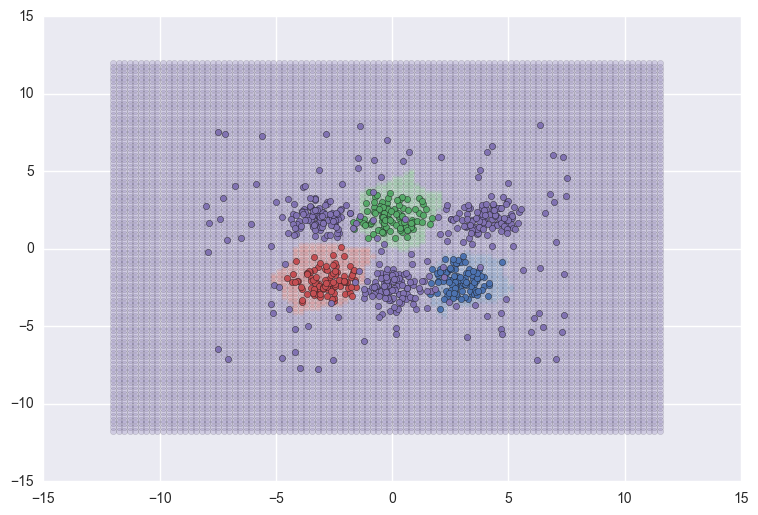

In [27]:
n=100
grid = np.empty((n**2, 2))
m = 4
xmin, xmax = np.min(x[:,0])-m, np.max(x[:,0])+m
ymin, ymax = np.min(x[:,1])-m, np.max(x[:,1])+m
for i, x0 in enumerate(np.linspace(xmin, xmax, n)):
    for j, y0 in enumerate(np.linspace(ymin, ymax, n)):
        grid[i*n+j, 0] = x0
        grid[i*n+j, 1] = y0
        
grid_preds = model.predict(grid)

fig, ax = plt.subplots(1, figsize=(9,6))# grid
c = grid[grid_preds == 0]
ax.scatter(c[:,0], c[:,1], c='r', alpha=.25)
c = grid[grid_preds == 1]
ax.scatter(c[:,0], c[:,1], c='b', alpha=.25)
c = grid[grid_preds == 2]
ax.scatter(c[:,0], c[:,1], c='g', alpha=.25)
c = grid[grid_preds == 3]
ax.scatter(c[:,0], c[:,1], c='m', alpha=.25)

# pred data
# c = x[preds == 0]
# plt.scatter(c[:,0], c[:,1], c='r')
# c = x[preds == 1]
# plt.scatter(c[:,0], c[:,1], c='b')
# c = x[preds == 2]
# plt.scatter(c[:,0], c[:,1], c='g')

# true data
c = x[y == 0]
ax.scatter(c[:,0], c[:,1], c='r')
c = x[y == 1]
ax.scatter(c[:,0], c[:,1], c='b')
c = x[y == 2]
ax.scatter(c[:,0], c[:,1], c='g')
c = x[y == 3]
ax.scatter(c[:,0], c[:,1], c='m')

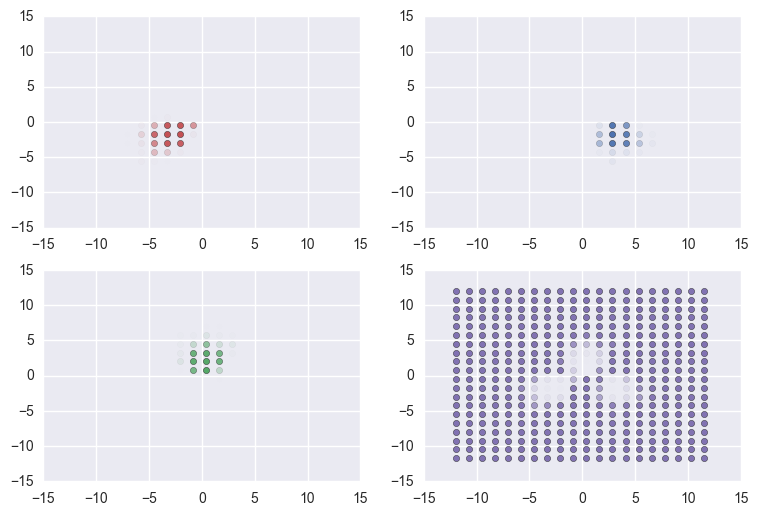

In [28]:
n=20
grid = np.empty((n**2, 2))
m = 4
xmin, xmax = np.min(x[:,0])-m, np.max(x[:,0])+m
ymin, ymax = np.min(x[:,1])-m, np.max(x[:,1])+m
for i, x0 in enumerate(np.linspace(xmin, xmax, n)):
    for j, y0 in enumerate(np.linspace(ymin, ymax, n)):
        grid[i*n+j, 0] = x0
        grid[i*n+j, 1] = y0
        
grid_probs = model.predict_proba(grid)

fig, axs = plt.subplots(2,2, figsize=(9,6))# grid
for i, x0 in enumerate(grid):
    axs[0,0].scatter(x0[0], x0[1], c='r', alpha=grid_probs[i,0])
    axs[0,1].scatter(x0[0], x0[1], c='b', alpha=grid_probs[i,1])
    axs[1,0].scatter(x0[0], x0[1], c='g', alpha=grid_probs[i,2])
    axs[1,1].scatter(x0[0], x0[1], c='m', alpha=grid_probs[i,3])
